In [1]:
import os
os.environ['HF_HOME'] = '/data1/malto/cache'

In [2]:
from transformers import Trainer
import torch.nn as nn
import torch

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        p_hall = inputs.pop("p(Hallucination)")
        cond_weights = inputs.pop("C-W")
        #cond_weights = torch.where(cond_weights > 0.5, 1.1, 0.1)
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")[:, 0]
        loss_fn = nn.BCEWithLogitsLoss(reduction='none')
        loss = cond_weights * loss_fn(logits, p_hall)
        loss = loss.mean()
        return (loss, outputs) if return_outputs else loss

    """def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys):
        phall = inputs.pop("p(Hallucination)")
        cw = inputs.pop("C-W")
        loss, logits, labels = super().prediction_step(model, inputs, prediction_loss_only, ignore_keys)
        inputs['p(Hallucination)'] = phall
        inputs['C-W'] = cw
        loss = self.compute_loss(model, inputs)
        return loss, logits, labels"""

In [3]:
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
from pathlib import Path
import scipy

os.environ['TOKENIZERS_PARALLELISM'] = "false"
os.environ["WANDB_DISABLED"] = "true"

BATCH_SIZE = 48
NUM_EPOCHS = 5
BASE_DIR = Path("/data1/malto/shroom/")

FREEZE = True
FROZEN_LAYERS = 15
USE_SEQUENTIAL = False

#checkpoint = "microsoft/deberta-xlarge-mnli"
#checkpoint = "microsoft/deberta-large-mnli"
#checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
checkpoint = "microsoft/deberta-v3-base"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/data1/malto/fborra/venv/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [4]:
def preprocess_function(examples): # not batched
    model_inputs = tokenizer(examples['hyp'], examples['tgt'] if examples['ref'] != 'src' else examples['src'], truncation=True, max_length=80)
    model_inputs["labels"] = [1 if t == "Hallucination" else 0 for t in examples['labels']]
    return model_inputs

def compute_metrics(eval_pred):
    #print(eval_pred)
    accuracy = evaluate.load("accuracy")
    predictions, labels = eval_pred
    #print(predictions, labels)
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "Not Hallucination", 1: "Hallucination"}
label2id = {"Not Hallucination": 0, "Hallucination": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

/data1/malto/fborra/venv/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
if USE_SEQUENTIAL:
    model.classifier = nn.Sequential(
        nn.Linear(in_features=1024, out_features=2048, bias=True),
        nn.Sigmoid(),
        nn.Linear(in_features=2048, out_features=2, bias=True)
    )


In [6]:
if FREEZE == True and checkpoint.startswith("microsoft"):
    print("freezing...")
    for param in model.deberta.embeddings.parameters():
        param.requires_grad = False
    for param in model.deberta.encoder.layer[:FROZEN_LAYERS].parameters():
        param.requires_grad = False

freezing...


In [7]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
# dataset manipulation

syntetic_test_size_split = 0.8

ds_mt = load_dataset("json", data_files=[str(BASE_DIR / f"train_labeled_MT_SOLAR.model-agnostic.json")])
ds_dm = load_dataset("json", data_files=[str(BASE_DIR / f"train_labeled_DM_SOLAR.model-agnostic.json")])
ds_pg = load_dataset("json", data_files=[str(BASE_DIR / f"train_labeled_PG_SOLAR.model-agnostic.json")])
ds_val = load_dataset("json", data_files=[str(BASE_DIR / f"val.model-agnostic.json")])
ds_val_aware = load_dataset("json", data_files=[str(BASE_DIR / f"val.model-aware.json")])
ds_gpt = load_dataset("json", data_files=str(BASE_DIR / f"transformed_val_model_gpt.json"))

ds_mt = ds_mt.remove_columns([el for el in ds_mt['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=syntetic_test_size_split)
ds_dm = ds_dm.remove_columns([el for el in ds_dm['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=syntetic_test_size_split)
ds_pg = ds_pg.remove_columns([el for el in ds_pg['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=syntetic_test_size_split)
ds_gpt = ds_gpt.remove_columns([el for el in ds_pg['train'].column_names if el not in ds_val['train'].column_names])['train'].train_test_split(test_size=syntetic_test_size_split)


ds = concatenate_datasets([ds_mt['train'], ds_dm['train'], ds_pg['train'], ds_val['train'], ds_gpt['train']])
ds = ds.shuffle()
ds = DatasetDict({
    'train' : ds,
    'test' : ds_val_aware['train'],
})
ds = ds.map(preprocess_function)
ds = ds.remove_columns(['hyp', 'src', 'task', 'ref', 'tgt', 'model', 'labels', 'label'])

ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6499 [00:00<?, ? examples/s]

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['C-W', 'p(Hallucination)', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6499
    })
    test: Dataset({
        features: ['p(Hallucination)', 'C-W', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 501
    })
})

In [9]:
training_args = TrainingArguments(
    output_dir="/data1/malto/shroom/checkpoint/local_model",
    learning_rate=1e-3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    logging_steps=1,
    report_to="none",
    remove_unused_columns=False,
)

trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=ds["train"],
        eval_dataset=ds["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        #compute_metrics=compute_metrics,
    )

trainer.label_names = []
trainer.can_return_loss = True

array([[<Axes: title={'center': '0'}>]], dtype=object)

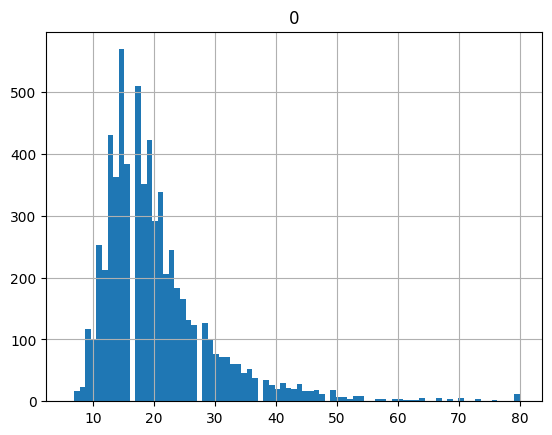

In [11]:
import pandas as pd

df = pd.DataFrame([len(el) for el in ds['train']['input_ids']])
df.hist(bins=81)

In [12]:
trainer.evaluate()

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7598705291748047,
 'eval_runtime': 1.0327,
 'eval_samples_per_second': 485.15,
 'eval_steps_per_second': 10.652}

In [13]:
def get_accuracy():
    predictions, _, _ = trainer.predict(ds["test"])

    #predictions = scipy.special.softmax(predictions, axis=-1)
    #predictions = np.argmax(predictions, axis=-1)
    predictions = scipy.special.expit(predictions[:, 0])
    predictions = np.where(predictions > 0.5, 0, 1)

    references = np.where(np.array(ds['test']['p(Hallucination)']) > 0.5, 0, 1)

    accuracy = (predictions == references).sum() / predictions.shape[0]
    return accuracy

get_accuracy()

0.5888223552894212

In [ ]:
from IPython.display import clear_output

accs = []
for i in range(1):
    clear_output(wait=True)
    print(i)
    print(accs)
    trainer.train()
    accs.append(get_accuracy())
#clear_output(wait=True)
print(accs)

In [ ]:
import random 

name_model = f"{checkpoint.split('/')[-1]}_{syntetic_test_size_split}_{'frozen' if FREEZE else 'unfrozen'}_{FROZEN_LAYERS}_{BATCH_SIZE}_{NUM_EPOCHS}_{accs[-1].round(3)}_{int(100*random.random())}{'_sequential' if USE_SEQUENTIAL else ''}"

predictions, _, _ = trainer.predict(ds["test"])
predictions = scipy.special.expit(predictions[:, 0])
predictions

df = pd.DataFrame(predictions, columns=[name_model])
df

In [ ]:
dataframe = pd.read_csv(f"/data1/malto/shroom/predictions_last.csv")
dataframe[name_model] = df[name_model]
dataframe.to_csv(f"/data1/malto/shroom/predictions_last.csv", index=False)

# Submission Generation

In [ ]:
ds_test = load_dataset("json", data_files=[str(BASE_DIR / "test.model-agnostic.json")])
ds_test

In [ ]:
def preprocess_function_test(examples): # not batched
    model_inputs = tokenizer(examples['hyp'], examples['tgt'], truncation=True, max_length=80)
    return model_inputs
def add_columns(examples):
    return {'p(Hallucination)' : 0.01, 'C-W': 1.01}

ds_test = ds_test.map(preprocess_function_test).remove_columns(['tgt', 'task', 'src', 'id', 'hyp']).map(add_columns, batched=False)

In [ ]:
import scipy
predictions, _, _ = trainer.predict(ds_test["train"])

probabilities = scipy.special.expit(predictions[:, 0])
predictions = np.where(probabilities > 0.5, "Hallucination", "Not Hallucination")

In [ ]:
ds_test_new = load_dataset("json", data_files=[str(BASE_DIR / "test.model-agnostic.json")])

global count
count = 0
def add_predictions(examples):
    global count
    prob = probabilities[count]
    pred = predictions[count]
    count += 1
    return {'p(Hallucination)' : prob, 'label' : pred}
ds_test_new = ds_test_new.map(add_predictions).remove_columns(['tgt', 'task', 'src', 'hyp'])

In [ ]:
ds_test_new['train'].to_json(str(BASE_DIR / "submission.json"))

In [ ]:
import json
label = "a_lr1e-4"

l = [el for el in ds_test_new['train']]
with open(BASE_DIR / f"submission_{label}.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(l))

## Ensemble

In [ ]:
# open json file 
f = open(BASE_DIR / "submission_a_lr1e-4.json",)
f = json.load(f)
f1 = open(BASE_DIR / "submission_a.json",)
f1 = json.load(f1)

# dataframe from json file 
df = pd.DataFrame(f)
df1 = pd.DataFrame(f1)
df1 = df1.rename(columns={'p(Hallucination)': 'p(Hallucination)_a'})

final_df = pd.concat([df, df1], axis=1)

# for each row evaluate correlation between p(Hallucination) and p(Hallucination)_{label}

from scipy.stats import pearsonr
pearsonr(final_df['p(Hallucination)'], final_df['p(Hallucination)_a'])

In [ ]:
ids = np.linspace(0, 1000, 1001, dtype=int)
 
p_hallucination = np.random.rand(1001)
labels = np.where(p_hallucination > 0.5, "Hallucination", "Not Hallucination")

i = 0 

ids[0], p_hallucination[0], labels[0]

In [ ]:
# make 5 dataframes with 5 different seeds of 3 columns (id, p(Hallucination), label), where id is shared across all 5 dataframes
import pandas as pd 

ids = np.linspace(0, 1000, 1001, dtype=int)
dataframes = []

for i in range(5): 
    p_hallucination = np.random.rand(1001)
    labels = np.where(p_hallucination > 0.5, "Hallucination", "Not Hallucination")
    df = pd.DataFrame({f"id_{i}": ids, f"p(Hallucination)_{i}": p_hallucination, f"label_{i}": labels})
    dataframes.append(df)


In [ ]:
def make_ensemble(dataframes: list) -> pd.DataFrame:
    # the function works with 5 dataframes of 3 columns (id, p(Hallucination), label), where id is shared across all 5 dataframes    
    df = pd.concat(dataframes, axis=1)

    assert df['id_0'].equals(df['id_1'])
    assert df['id_0'].equals(df['id_2'])
    assert df['id_0'].equals(df['id_3'])
    assert df['id_0'].equals(df['id_4'])
    df = df.drop(columns=['id_1', 'id_2', 'id_3', 'id_4'])
    df.rename(columns={'id_0': 'id'}, inplace=True)

    df['p(Hallucination)'] = df.loc[:, df.columns.str.startswith('p(Hallucination)')].mean(axis=1)
    df = df.drop(columns=['p(Hallucination)_0', 'p(Hallucination)_1', 'p(Hallucination)_2', 'p(Hallucination)_3', 'p(Hallucination)_4', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4'])
    
    df['label'] = np.where(df['p(Hallucination)'] > 0.5, "Hallucination", "Not Hallucination")
    return df

In [ ]:
ds_ensemble = make_ensemble(dataframes)

In [ ]:
import json

l = [el for el in ds_ensemble]
with open(BASE_DIR / "ensemble_submission.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(l))

# Output analysis

In [21]:
dataframe['Ground Truth'] = ds_val_aware['train']['p(Hallucination)']

In [14]:
dataframe = pd.read_csv(f"/data1/malto/shroom/predictions_last.csv")
dataframe

,deberta-large-mnli_0.8_frozen_15_48_1_2_sequential,deberta-large-mnli_1_frozen_15_48_1_2_sequential,deberta-large-mnli_1_unfrozen_15_48_1_0.589_27_sequential,deberta-large-mnli_1_frozen_20_48_1_0.754_63_sequential,deberta-large-mnli_1_frozen_22_48_1_0.743_63_sequential,deberta-large-mnli_1_frozen_22_48_1_0.743_63,deberta-large-mnli_1_frozen_20_48_1_0.758_63,deberta-v3-base_1_frozen_15_48_1_0.589_63,deberta-v3-base_1_frozen_15_48_10_0.667_63,deberta-v3-base_1_frozen_15_48_10_0.687_63,deberta-v3-base_0.8_frozen_15_48_5_0.681_2
0,0.343735,0.603618,0.249643,0.500327,0.407393,0.383033,0.404245,0.288269,0.444964,0.498349,0.484773
1,0.146282,0.063459,0.249642,0.034334,0.033249,0.021072,0.043240,0.222452,0.109553,0.134768,0.188588
2,0.218340,0.375188,0.249643,0.259810,0.383049,0.254702,0.336714,0.224975,0.119793,0.139098,0.096675
3,0.459515,0.603531,0.249643,0.471194,0.434684,0.413301,0.389070,0.243606,0.449309,0.484880,0.530016
4,0.281909,0.353008,0.249642,0.358291,0.313899,0.304283,0.371249,0.366357,0.332524,0.383707,0.415468
...,...,...,...,...,...,...,...,...,...,...,...
496,0.839619,0.603688,0.249643,0.924985,0.934798,0.952157,0.951343,0.318822,0.700243,0.713203,0.774486
497,0.076096,0.018521,0.249642,0.012420,0.051991,0.030068,0.018866,0.253782,0.177519,0.178438,0.277909
498,0.367880,0.196608,0.249642,0.322370,0.266778,0.311967,0.281362,0.245802,0.227338,0.231014,0.238293
499,0.823301,0.604032,0.249643,0.804742,0.847927,0.822811,0.909890,0.319243,0.684022,0.715983,0.824590


In [29]:
dataframe['avg'] = (dataframe['deberta-large-mnli_1_frozen_22_48_1_0.743_63_sequential'] + dataframe['deberta-v3-base_0.8_frozen_15_48_5_0.681_2']) / 2

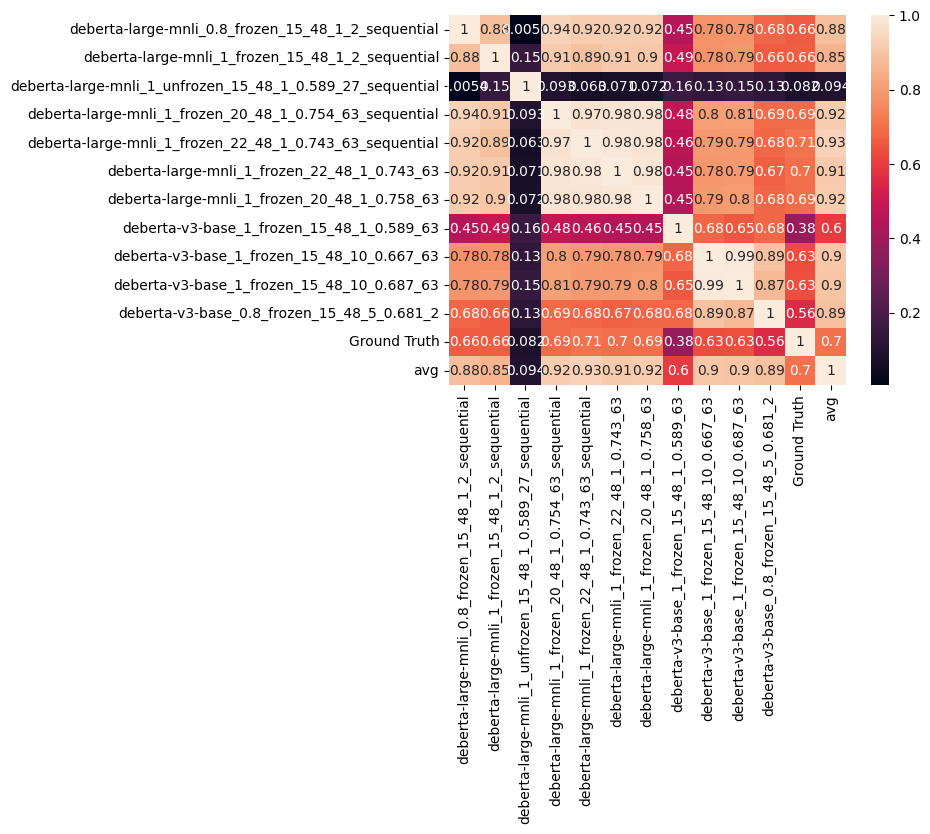

In [30]:
# correlation matrix of dataframe 
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = dataframe.corr(method='spearman')
sn.heatmap(corrMatrix, annot=True)
plt.show()